In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1
Code a simulation algorithm to compute how massive (because otherwise the effect of universal gravitation would be negligible) objects would gravitationally interact with each other in space, given initial conditions such as mass of object, size of object, initial velocity, etc. Using the simulation algorithm, attempt to recreate a plot of our solar system.

In [2]:
# define constants
G = 6.67e-11 # gravitational cosntant


class Object:
    def __init__(self, name, mass, radius, v_init, init_coord):
        '''
        mass: mass of the object in kg
        radius: the radius of the object (assume to be a sphere, or a circle in 2D) in meters
        v_init: initial velocity in m/s
        init_coord: tuple, the x and y coordinates of the object
        '''
        self.name = name
        self.mass = mass
        self.radius = radius
        self.v = [v_init]
        self.a = [0]
        self.x = [init_coord[0]]
        self.y = [init_coord[1]]
        self.path = [(init_coord[0], init_coord[1])]


In [3]:
class OrbitSimulation:
    def __init__(self, objects, G, delta_t):
        '''
        objects: a list of planets/objects
        '''
        self.objects = objects
        self.timestep = 0
        self.G = G
        self.dt = delta_t

    def distance_between_squared(self, ob1, ob2):
        return ((ob1.x[-1] - ob2.x[-1])**2 + (ob1.y[-1]-ob2.y[-1])**2)
    
    def total_gravity_force(self, ob):
        g_force = np.zeros(2) # 2-D vector
        for obs in self.objects:
            if ob.name != obs.name:
                r_hat = [obs.x[-1]-ob.x[-1], obs.y[-1]-ob.y[-1]] # the direction of the force
                norm_r = np.array(r_hat)/((obs.x[-1] - ob.x[-1])**2 + (obs.y[-1]-ob.y[-1])**2)**(1/2) # unit vector
                gravity = self.G * ob.mass * obs.mass /self.distance_between_squared(ob, obs)
                g_vec = gravity * norm_r 
                g_force += g_vec
        return g_force
    
    def step(self):
        new_pos = [] # new positions, we use the old positions for the acceleration and velocity
        for ob in self.objects:
            # update acceleration (from force), then velocity, then position
            g_force = self.total_gravity_force(ob)
            a = g_force/ob.mass
            ob.a.append(a)
            # update velocity 
            ob.v.append(ob.v[-1] + a * self.dt)
            # update position
            x, y = ob.x[-1] + ob.v[-1][0] * self.dt, ob.y[-1] + ob.v[-1][1] * self.dt
            new_pos.append((x,y))
        for i, ob in enumerate(self.objects):
            ob.x.append(new_pos[i][0])
            ob.y.append(new_pos[i][1])
        self.timestep += 1
    
    
    def show(self):
        # t = [i for i in range(self.timestep+1)]
        for obj in self.objects:
            plt.scatter(obj.x, obj.y, label=obj.name)
        plt.legend()
        plt.title(f"Timestep: {self.timestep}")
        plt.show()
                    
            
        

In [4]:
# name, mass, radius, v_init, init_coord
G = 6.673e-11
sun = Object("Sun", 1.989e30, 696340000, [0,0], [0,0])
# earth
sun_earth_distance = 149597870700 
earth_init_velocity = np.sqrt(G*1.989e30/sun_earth_distance)
earth = Object("Earth", 5.9722e24, 6371000, [0, earth_init_velocity], [sun_earth_distance,0])
# mercury
sun_mercury_distance = 53.887e9
mercury_init_velocity = np.sqrt(G*1.989e30/sun_mercury_distance)
mercury = Object("Mercury", 3.285e23, 2439700, [0, mercury_init_velocity], [sun_mercury_distance,0])
# venus
sun_venus_distance = 107.51e9
venus_init_velocity = np.sqrt(G*1.989e30/sun_venus_distance)
venus = Object("Venus", 4.867e24, 6051800, [0, venus_init_velocity], [sun_venus_distance,0])
# mars
sun_mars_distance = 214.05e9
mars_init_velocity = np.sqrt(G*1.989e30/sun_mars_distance)
mars = Object("Mars", 6.39e23, 3389500, [0, mars_init_velocity], [sun_mars_distance,0])

objects = [sun, earth, mercury, venus, mars]
orbit_sim = OrbitSimulation(objects, G, 24*60*60)

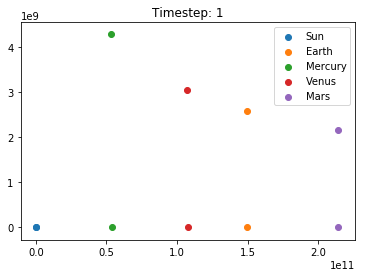

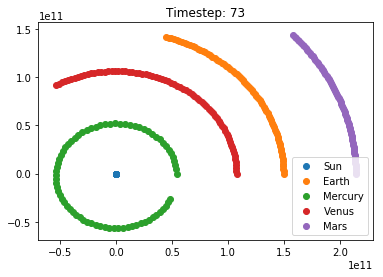

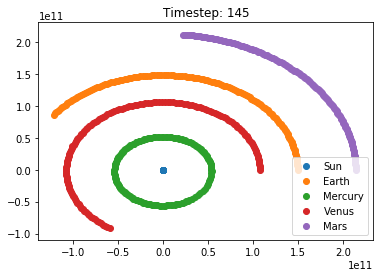

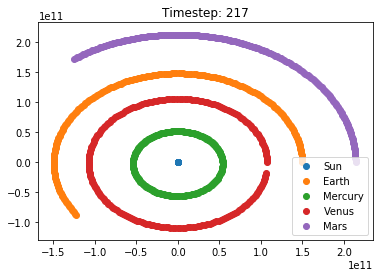

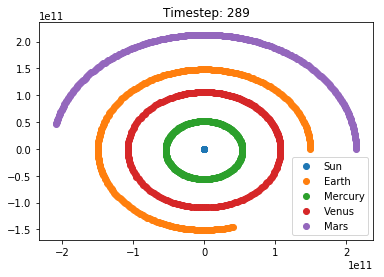

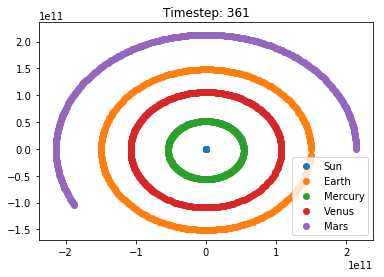

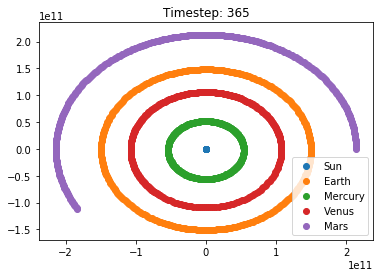

In [5]:
for _ in range(365):
    orbit_sim.step()
    if _ % (72) == 0:
        orbit_sim.show()
orbit_sim.show()


Given information about the planets (mass, initial velocity, distance from the sun ... etc), we can use the update functions derived from the law of gravity to map out the orbits of our solar system. The simulation is very sensitive to the initial condition, any changes in the initial condition (if the distance between the sun and earth is halved) could result in a drastically different result. This goes to show the beauty of our solar system and how unlikely it is that we have our system today.

# Question 2
Code a simulation algorithm to compute the outcome of a collision given an initial condition. Feel free to interpret “outcome” liberally; create at least one visualization explaining your finding.

In the simulation, our particles experience a "collision" when the distance between the center of the two particles are less than or equal to the sum of their radius. This simulation only supports a two-particle collision, any collision involving more particles would require a more complex update function.

When the collision occur, we use the following updates:
$$\vec v_1 = \frac{m_1 - m_2}{m_1+m_2}\vec u_1 + \frac{2m_2}{m_1+m_2} \vec u_2$$
$$\vec v_2 = \frac{2m_1}{m_1+m_2}\vec u_1 + \frac{m_2-m_1}{m_1+m_2} \vec u_2$$

In [6]:
class Particle:
    def __init__(self, name, mass, init_velocity, init_coord, radius):
        self.name = name
        self.mass = mass
        self.v = init_velocity
        self.coord = init_coord
        self.radius = radius
        self.x_path = [init_coord[0]]
        self.y_path = [init_coord[1]]
        self.collided = False

        
class Collision_Simulation:
    def __init__(self, objects, delta):
        self.timestep = 0
        self.objects = objects
        self.dt = delta
    
    def distance_between(self, ob1, ob2):
        return ((ob1.coord[0] - ob2.coord[0])**2 + (ob1.coord[1]-ob2.coord[1])**2)**(1/2)
    
    
    def collisions(self, ob, indx):
        for obj in self.objects[indx:]:
            if ob.name != obj.name and (not ob.collided or not obj.collided): 
                # can only experience collision once in an instant 
                distance = self.distance_between(ob, obj)
                if distance <= (ob.radius + obj.radius):
                    # collision ocurred
                    # compute direction
                    final1 = (ob.mass-obj.mass)/(ob.mass+obj.mass) * ob.v + (2*obj.mass)/(ob.mass+obj.mass) * obj.v
                    final2 = (2*ob.mass)/(ob.mass+obj.mass) * ob.v + (obj.mass-ob.mass)/(ob.mass+obj.mass) * obj.v
                    
                    ob.v = final1
                    obj.v = final2
                    ob.collided = True
                    obj.collided = True
                
    def step(self):
        self.timestep += 1
        for obj in self.objects:
            # update positions
            obj.coord += obj.v * self.dt
            obj.x_path.append(obj.coord[0])
            obj.y_path.append(obj.coord[1])
        # check for collisions
        for i, obj in enumerate(self.objects):
            self.collisions(obj, i)
        for obj in self.objects: # reset collisions
            obj.collided = False
        
        
        
    
    def show(self):
        largest = 0
        for obj in self.objects:
            if obj.radius > largest:
                largest = obj.radius
        
        
        for obj in self.objects:
            plt.scatter(obj.x_path, obj.y_path, label=obj.name, s=int(obj.radius/largest * 500))
        plt.legend()
        plt.show()
        
        

In [7]:
# self, name, mass, init_velocity, init_coord, radius
a = Particle("1", 10, np.array([100, 0], dtype='float64'), np.array([0,0], dtype='float64'), 5)
b = Particle("2", 15, np.array([-10, 0], dtype='float64'), np.array([200, 0], dtype='float64'), 2)
objects = [a,b]
sim = Collision_Simulation(objects, 0.1)

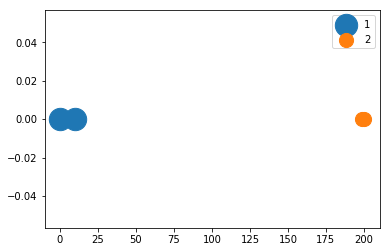

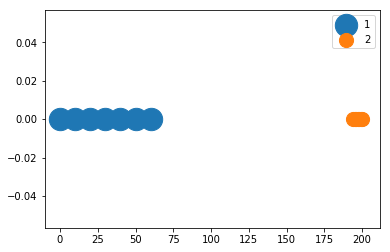

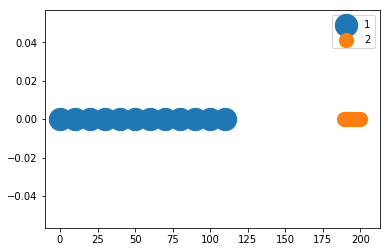

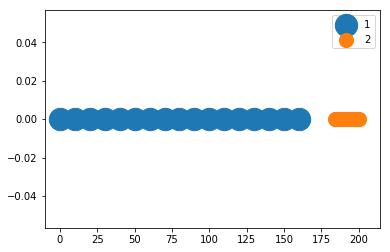

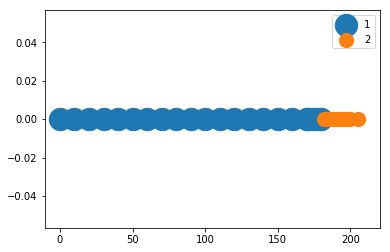

In [8]:
# Vertical collision
for _ in range(21):
    sim.step()
    if _ %5 == 0:
        sim.show()

In [9]:
a = Particle("1", 10, np.array([10, 0], dtype='float64'), np.array([0,0], dtype='float64'), 15)
b = Particle("2", 15, np.array([-10, -2], dtype='float64'), np.array([10, 2], dtype='float64'), 12)
objects = [a,b]
sim = Collision_Simulation(objects, 0.1)

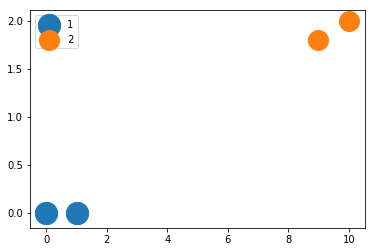

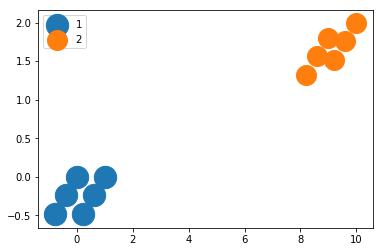

In [10]:
for _ in range(6):
    sim.step()
    if _ %4 == 0:
        sim.show()

We can see that in two scenarios both particles experienced collisions and are headed in opposite directions. In the second scenario, the scale of the plot made it seem like the two particles didn't make contact, but because both partcles have large radius that didn't show up in the plot, they actually encountered multiple collisions.